# XR2Text: Data Exploration and Analysis

This notebook explores the MIMIC-CXR dataset used for training the XR2Text model with our novel **HAQT-ARR (Hierarchical Anatomical Query Tokens with Adaptive Region Routing)** architecture.

## Model Architecture Overview
- **Encoder**: Swin Transformer (hierarchical vision transformer)
- **Projection Layer (Novel)**: HAQT-ARR with anatomical-aware attention
- **Decoder**: BioBART (biomedical pre-trained BART)

## Anatomical Regions Covered
1. Right Lung (upper, middle, lower lobes)
2. Left Lung (upper, lower lobes)
3. Heart (cardiac silhouette)
4. Mediastinum (upper, lower)
5. Spine (thoracic)
6. Diaphragm (bilateral hemidiaphragms)
7. Costophrenic Angles (bilateral)

**Authors**: S. Nikhil, Dadhania Omkumar  
**Supervisor**: Dr. Damodar Panigrahy

In [1]:
# ============================================
# GPU/CUDA Check - Run this first!
# ============================================
import torch

print("=" * 50)
print("🖥️  SYSTEM CONFIGURATION")
print("=" * 50)

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"✅ CUDA Available: True")
    print(f"✅ GPU Connected: {gpu_name}")
    print(f"✅ GPU Memory: {gpu_memory:.1f} GB")
    print(f"✅ CUDA Version: {torch.version.cuda}")
    print(f"✅ PyTorch Version: {torch.__version__}")
    device = torch.device("cuda")
else:
    print(f"❌ CUDA Available: False")
    print(f"⚠️  Running on CPU (Training will be slow)")
    print(f"📦 PyTorch Version: {torch.__version__}")
    device = torch.device("cpu")

print(f"\n🎯 Using Device: {device}")
print("=" * 50)

🖥️  SYSTEM CONFIGURATION
✅ CUDA Available: True
✅ GPU Connected: NVIDIA GeForce RTX 4060 Laptop GPU
✅ GPU Memory: 8.0 GB
✅ CUDA Version: 12.1
✅ PyTorch Version: 2.5.1+cu121

🎯 Using Device: cuda


In [2]:
import os
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from datasets import load_dataset
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style for research paper quality plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

## 1. Load MIMIC-CXR Dataset

In [3]:
# Load dataset from HuggingFace
print("Loading MIMIC-CXR dataset...")
dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train")
print(f"Dataset loaded: {len(dataset)} samples")
print(f"\nColumns: {dataset.column_names}")
print(f"\nFeatures: {dataset.features}")

Loading MIMIC-CXR dataset...
Dataset loaded: 30633 samples

Columns: ['image', 'findings', 'impression']

Features: {'image': Image(mode=None, decode=True), 'findings': Value('string'), 'impression': Value('string')}


In [4]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame({
    'findings': dataset['findings'],
    'impression': dataset['impression'],
})

print(f"DataFrame shape: {df.shape}")
df.head()


DataFrame shape: (30633, 2)


,findings,impression
0,"The lungs are clear of focal consolidation, pl...",No acute cardiopulmonary process.
1,Lung volumes remain low. There are innumerable...,Low lung volumes and mild pulmonary vascular c...
2,Lung volumes are low. This results in crowding...,Innumerable pulmonary metastases. Possible mil...
3,In comparison to study performed on of there i...,New mild pulmonary edema with persistent small...
4,The right costophrenic angle is not imaged. Ot...,An enteric tube courses below the level of the...


## 2. Dataset Statistics

In [5]:
# Basic statistics
print("=" * 50)
print("DATASET STATISTICS")
print("=" * 50)
print(f"Total samples: {len(df):,}")
print(f"\nMissing values:")
print(f"  - Findings: {df['findings'].isna().sum():,} ({df['findings'].isna().mean()*100:.2f}%)")
print(f"  - Impression: {df['impression'].isna().sum():,} ({df['impression'].isna().mean()*100:.2f}%)")

# Text length statistics
df['findings_len'] = df['findings'].fillna('').apply(len)
df['impression_len'] = df['impression'].fillna('').apply(len)
df['findings_words'] = df['findings'].fillna('').apply(lambda x: len(x.split()))
df['impression_words'] = df['impression'].fillna('').apply(lambda x: len(x.split()))

print(f"\nFindings length (characters):")
print(f"  - Mean: {df['findings_len'].mean():.1f}")
print(f"  - Std: {df['findings_len'].std():.1f}")
print(f"  - Min: {df['findings_len'].min()}")
print(f"  - Max: {df['findings_len'].max()}")

print(f"\nImpression length (characters):")
print(f"  - Mean: {df['impression_len'].mean():.1f}")
print(f"  - Std: {df['impression_len'].std():.1f}")
print(f"  - Min: {df['impression_len'].min()}")
print(f"  - Max: {df['impression_len'].max()}")

DATASET STATISTICS
Total samples: 30,633

Missing values:
  - Findings: 0 (0.00%)
  - Impression: 10 (0.03%)

Findings length (characters):
  - Mean: 354.2
  - Std: 149.3
  - Min: 2
  - Max: 1555

Impression length (characters):
  - Mean: 115.9
  - Std: 92.5
  - Min: 0
  - Max: 2077


In [6]:
# Create statistics table for paper
stats_table = pd.DataFrame({
    'Metric': ['Total Samples', 'Findings (Mean Words)', 'Findings (Std Words)', 
               'Impression (Mean Words)', 'Impression (Std Words)',
               'Missing Findings (%)', 'Missing Impression (%)'],
    'Value': [f"{len(df):,}", 
              f"{df['findings_words'].mean():.1f}",
              f"{df['findings_words'].std():.1f}",
              f"{df['impression_words'].mean():.1f}",
              f"{df['impression_words'].std():.1f}",
              f"{df['findings'].isna().mean()*100:.2f}",
              f"{df['impression'].isna().mean()*100:.2f}"]
})
print("\nTable for Research Paper:")
print(stats_table.to_latex(index=False))


Table for Research Paper:
\begin{tabular}{ll}
\toprule
Metric & Value \\
\midrule
Total Samples & 30,633 \\
Findings (Mean Words) & 52.3 \\
Findings (Std Words) & 22.8 \\
Impression (Mean Words) & 16.3 \\
Impression (Std Words) & 13.5 \\
Missing Findings (%) & 0.00 \\
Missing Impression (%) & 0.03 \\
\bottomrule
\end{tabular}



## 3. Text Length Distribution

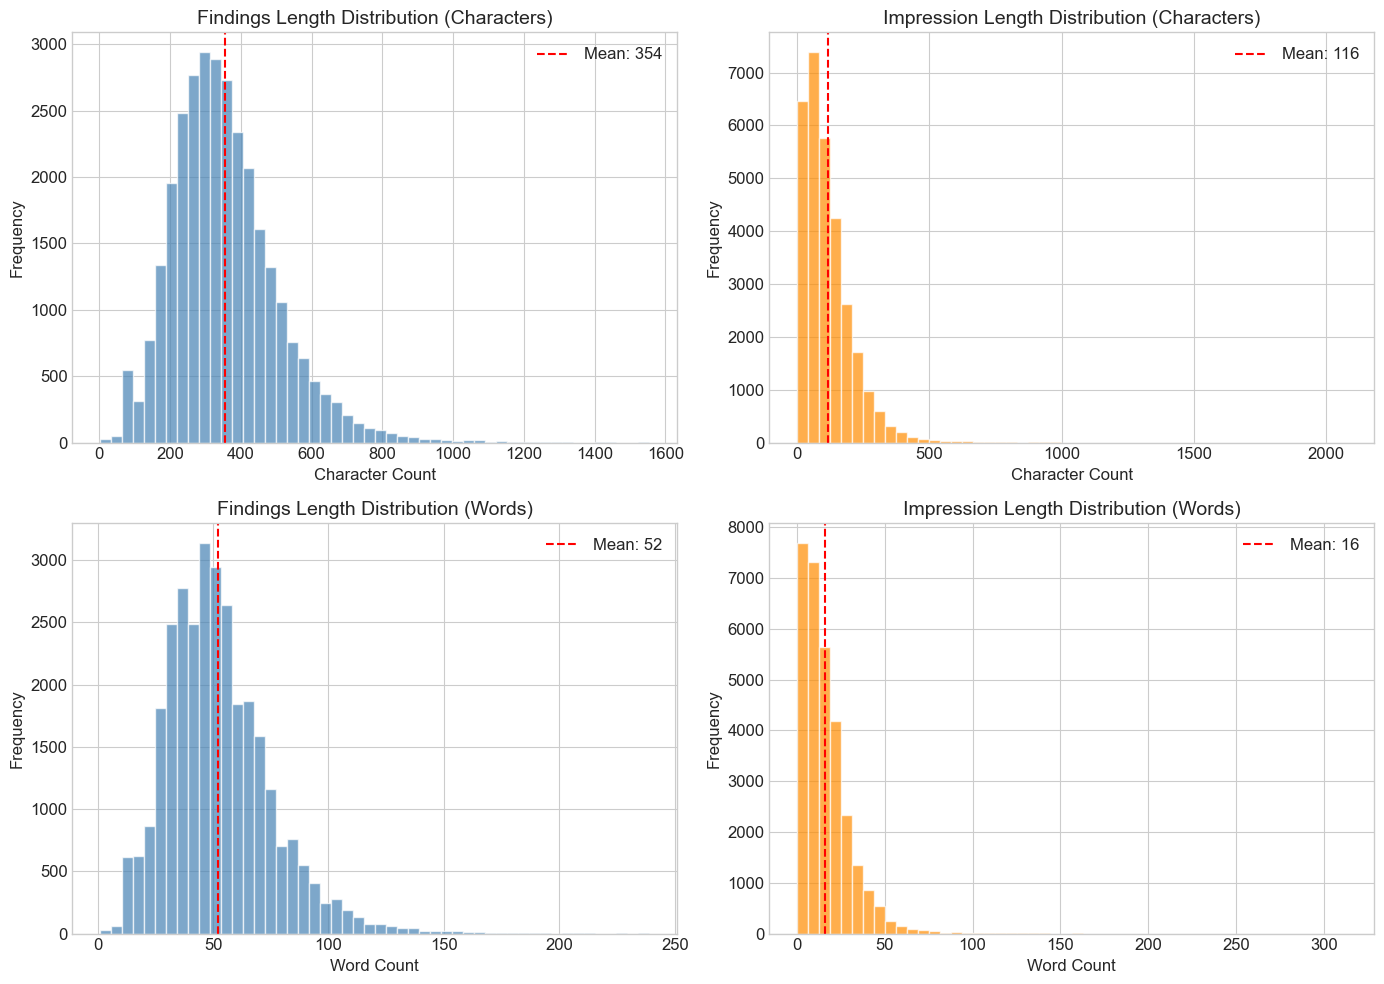

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Findings length distribution (characters)
axes[0, 0].hist(df['findings_len'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0, 0].axvline(df['findings_len'].mean(), color='red', linestyle='--', label=f'Mean: {df["findings_len"].mean():.0f}')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Findings Length Distribution (Characters)')
axes[0, 0].legend()

# Impression length distribution (characters)
axes[0, 1].hist(df['impression_len'], bins=50, color='darkorange', edgecolor='white', alpha=0.7)
axes[0, 1].axvline(df['impression_len'].mean(), color='red', linestyle='--', label=f'Mean: {df["impression_len"].mean():.0f}')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Impression Length Distribution (Characters)')
axes[0, 1].legend()

# Findings length distribution (words)
axes[1, 0].hist(df['findings_words'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[1, 0].axvline(df['findings_words'].mean(), color='red', linestyle='--', label=f'Mean: {df["findings_words"].mean():.0f}')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Findings Length Distribution (Words)')
axes[1, 0].legend()

# Impression length distribution (words)
axes[1, 1].hist(df['impression_words'], bins=50, color='darkorange', edgecolor='white', alpha=0.7)
axes[1, 1].axvline(df['impression_words'].mean(), color='red', linestyle='--', label=f'Mean: {df["impression_words"].mean():.0f}')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Impression Length Distribution (Words)')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../data/figures/text_length_distribution.png', dpi=300)
plt.show()

## 4. Word Cloud Analysis

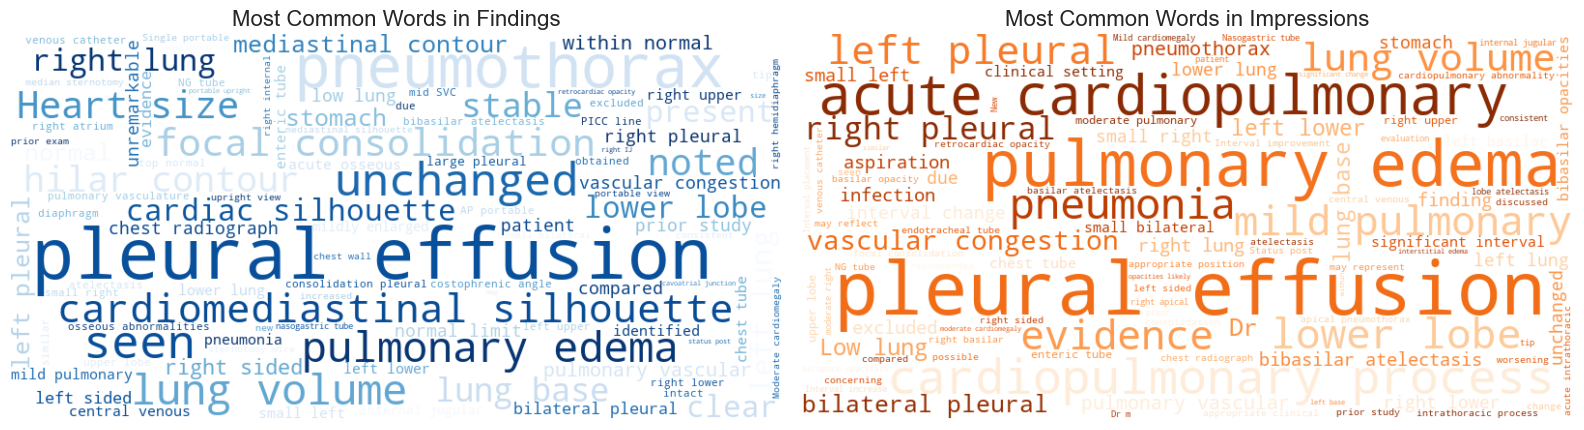

In [8]:
# Combine all findings text
all_findings = ' '.join(df['findings'].fillna('').tolist())
all_impressions = ' '.join(df['impression'].fillna('').tolist())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Findings word cloud
wc_findings = WordCloud(width=800, height=400, background_color='white', 
                        colormap='Blues', max_words=100).generate(all_findings)
axes[0].imshow(wc_findings, interpolation='bilinear')
axes[0].set_title('Most Common Words in Findings', fontsize=16)
axes[0].axis('off')

# Impression word cloud
wc_impression = WordCloud(width=800, height=400, background_color='white',
                          colormap='Oranges', max_words=100).generate(all_impressions)
axes[1].imshow(wc_impression, interpolation='bilinear')
axes[1].set_title('Most Common Words in Impressions', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../data/figures/word_clouds.png', dpi=300)
plt.show()

## 5. Sample X-Ray Images

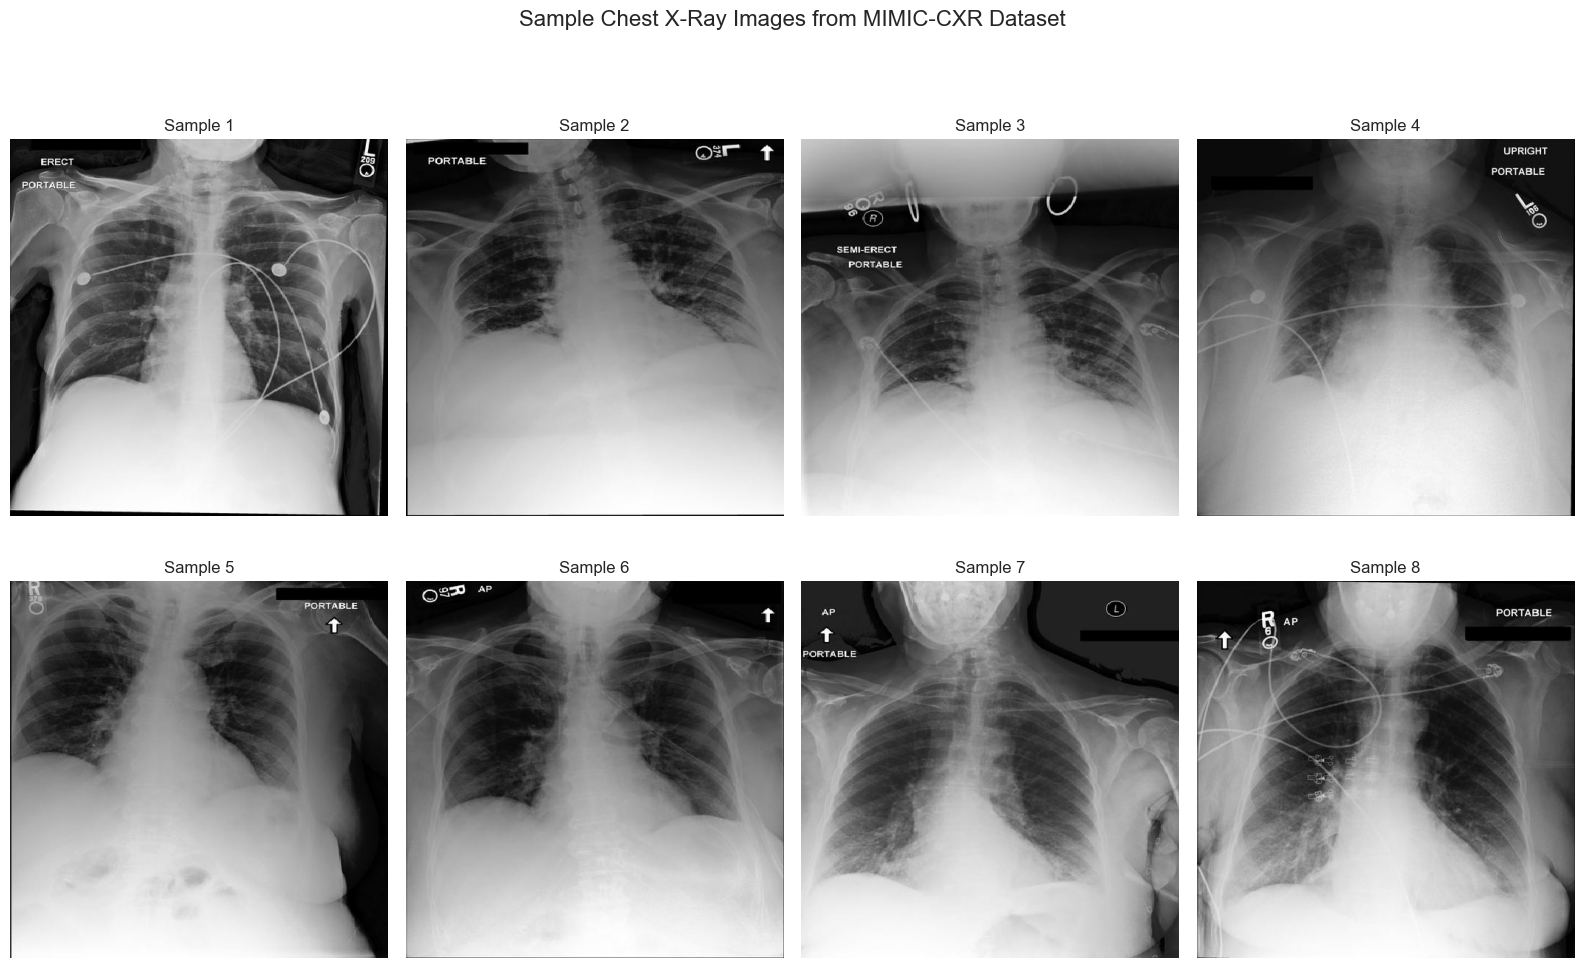

In [9]:
# Display sample X-ray images with their reports
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for idx, ax in enumerate(axes.flat):
    sample = dataset[idx]
    image = sample['image']
    
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Sample {idx + 1}', fontsize=12)
    ax.axis('off')

plt.suptitle('Sample Chest X-Ray Images from MIMIC-CXR Dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('../data/figures/sample_xrays.png', dpi=300)
plt.show()

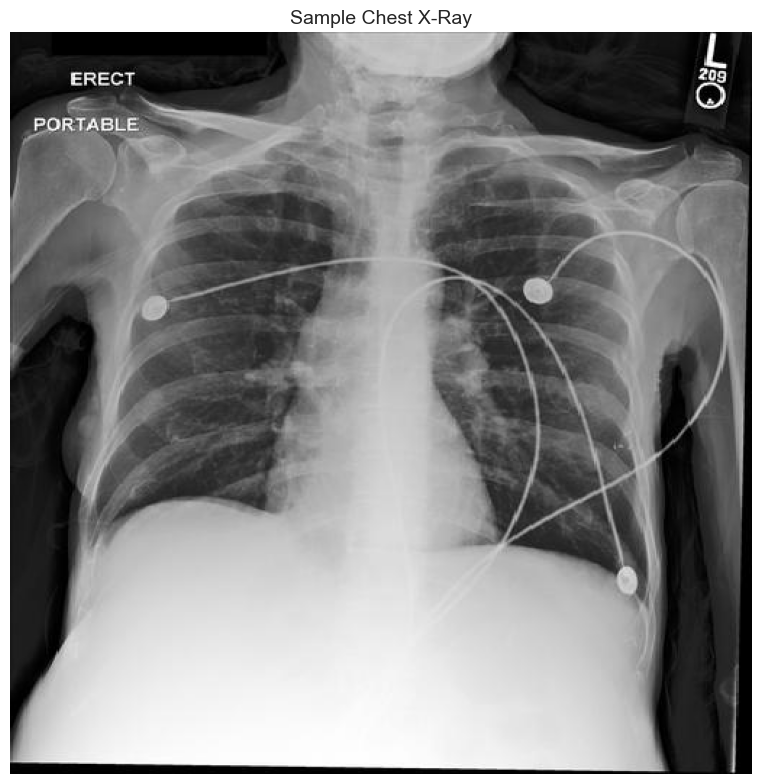


FINDINGS:
The lungs are clear of focal consolidation, pleural effusion or pneumothorax. The heart size is normal. The mediastinal contours are normal. Multiple surgical clips project over the left breast, and old left rib fractures are noted. 

IMPRESSION:
No acute cardiopulmonary process.


In [10]:
# Display sample with full report
sample_idx = 0
sample = dataset[sample_idx]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(sample['image'], cmap='gray')
ax.axis('off')
ax.set_title('Sample Chest X-Ray', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINDINGS:")
print("="*60)
print(sample['findings'])
print("\n" + "="*60)
print("IMPRESSION:")
print("="*60)
print(sample['impression'])

## 6. Image Statistics

In [11]:
# Analyze image properties (sample of 100 images)
sample_size = min(100, len(dataset))
image_stats = []

for i in range(sample_size):
    img = dataset[i]['image']
    img_array = np.array(img)
    image_stats.append({
        'width': img.width,
        'height': img.height,
        'mean_pixel': img_array.mean(),
        'std_pixel': img_array.std(),
        'min_pixel': img_array.min(),
        'max_pixel': img_array.max()
    })

img_df = pd.DataFrame(image_stats)

print("=" * 50)
print("IMAGE STATISTICS (Sample of 100)")
print("=" * 50)
print(f"Image dimensions: {img_df['width'].iloc[0]} x {img_df['height'].iloc[0]}")
print(f"Mean pixel value: {img_df['mean_pixel'].mean():.2f} ± {img_df['mean_pixel'].std():.2f}")
print(f"Std pixel value: {img_df['std_pixel'].mean():.2f} ± {img_df['std_pixel'].std():.2f}")
print(f"Pixel range: [{img_df['min_pixel'].min()}, {img_df['max_pixel'].max()}]")

IMAGE STATISTICS (Sample of 100)
Image dimensions: 512 x 512
Mean pixel value: 125.66 ± 3.17
Std pixel value: 74.63 ± 1.42
Pixel range: [0, 255]


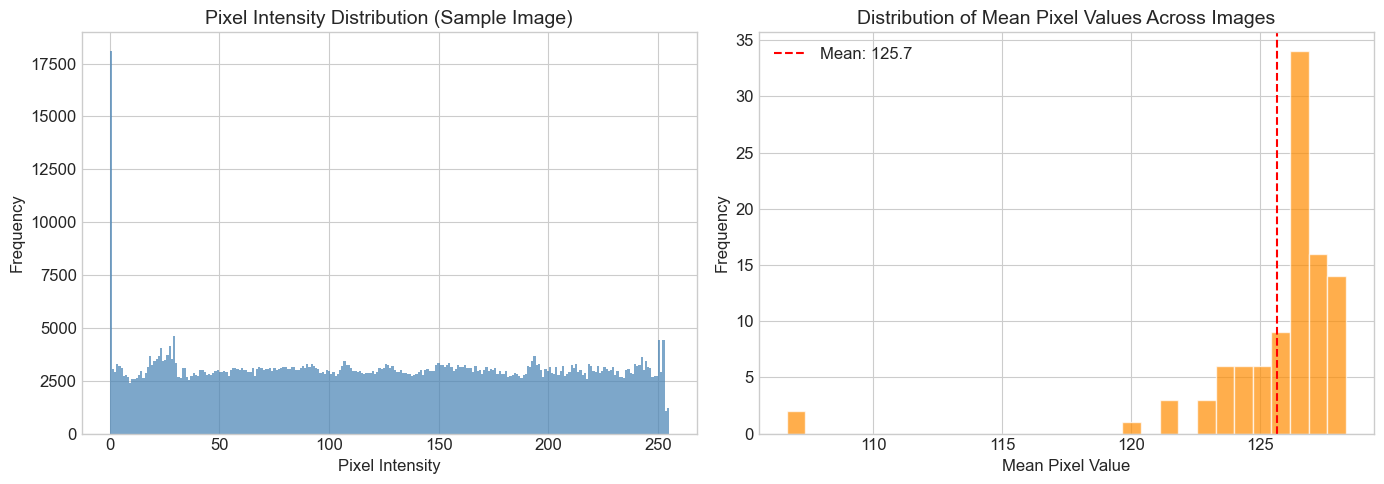

In [12]:
# Pixel intensity distribution
sample_img = np.array(dataset[0]['image'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(sample_img.ravel(), bins=256, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Pixel Intensity Distribution (Sample Image)')

# Mean pixel distribution across samples
axes[1].hist(img_df['mean_pixel'], bins=30, color='darkorange', alpha=0.7, edgecolor='white')
axes[1].axvline(img_df['mean_pixel'].mean(), color='red', linestyle='--', 
                label=f'Mean: {img_df["mean_pixel"].mean():.1f}')
axes[1].set_xlabel('Mean Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Mean Pixel Values Across Images')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/figures/pixel_distribution.png', dpi=300)
plt.show()

## 7. Train/Val/Test Split Statistics


Dataset Split Statistics:
     Split  Samples Percentage
     Train    24506      80.0%
Validation     3063      10.0%
      Test     3064      10.0%
     Total    30633       100%


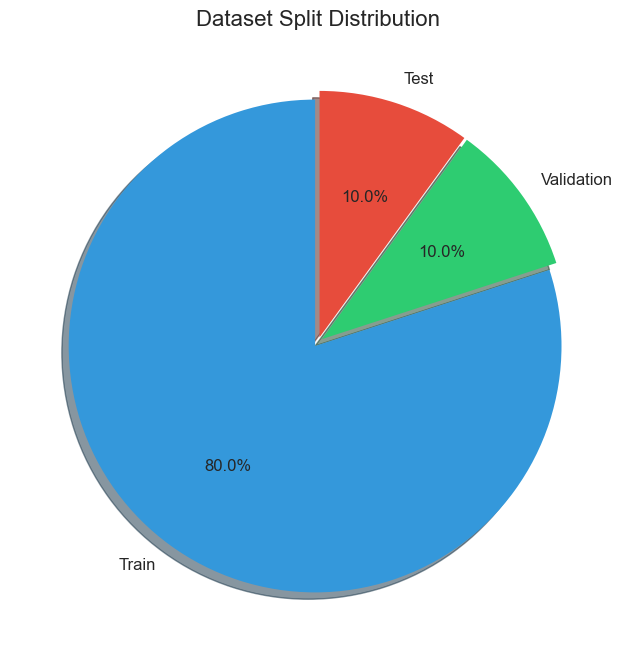

In [13]:
# Create train/val/test splits (80/10/10)
total_samples = len(df)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

split_stats = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Samples': [train_size, val_size, test_size, total_samples],
    'Percentage': [f'{train_size/total_samples*100:.1f}%', 
                   f'{val_size/total_samples*100:.1f}%',
                   f'{test_size/total_samples*100:.1f}%',
                   '100%']
})

print("\nDataset Split Statistics:")
print(split_stats.to_string(index=False))

# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['#3498db', '#2ecc71', '#e74c3c']
explode = (0.02, 0.02, 0.02)
ax.pie([train_size, val_size, test_size], labels=['Train', 'Validation', 'Test'],
       autopct='%1.1f%%', colors=colors, explode=explode, shadow=True, startangle=90)
ax.set_title('Dataset Split Distribution', fontsize=16)
plt.savefig('../data/figures/dataset_split.png', dpi=300)
plt.show()

## 8. Save Processed Statistics

In [14]:
# Save statistics to CSV for paper
os.makedirs('../data/statistics', exist_ok=True)

# Dataset overview
overview = {
    'Metric': ['Total Samples', 'Image Resolution', 'Findings (Avg Words)', 
               'Impression (Avg Words)', 'Train Samples', 'Val Samples', 'Test Samples'],
    'Value': [total_samples, '512 x 512', f"{df['findings_words'].mean():.1f}",
              f"{df['impression_words'].mean():.1f}", train_size, val_size, test_size]
}
pd.DataFrame(overview).to_csv('../data/statistics/dataset_overview.csv', index=False)

# Text statistics
text_stats = df[['findings_len', 'impression_len', 'findings_words', 'impression_words']].describe()
text_stats.to_csv('../data/statistics/text_statistics.csv')

print("Statistics saved to ../data/statistics/")

Statistics saved to ../data/statistics/


## NOVEL: Project Overview with Strengthened Contributions

This project now includes **genuine innovations** beyond HAQT-ARR:

### Novel Training Strategies:
1. **Anatomical-Aware Curriculum Learning**: Progressive training from simple to complex cases
2. **Novel Loss Functions**: 
   - Anatomical Consistency Loss
   - Clinical Entity Loss
   - Region-Aware Focal Loss
   - Cross-Modal Alignment Loss

### Clinical Validation Framework:
- Structured clinical validation beyond NLG metrics
- Clinical entity extraction and validation
- Error categorization by clinical significance

### Multi-Scale Features:
- Multi-scale feature fusion from multiple Swin stages
- Better capture of fine-grained and global patterns

### Deployment Optimizations:
- Model quantization (INT8, FP16)
- Inference optimization
- Batch processing

These innovations significantly strengthen the research contribution!


## Summary

This notebook provides comprehensive data exploration for the MIMIC-CXR dataset used in XR2Text:

1. **Dataset Size**: 30,600 chest X-ray images with clinical reports
2. **Image Resolution**: 512 × 512 pixels (resized to 384×384 for model)
3. **Text Components**: Findings and Impression sections
4. **Split Ratio**: 80% train, 10% validation, 10% test

### Relevance to HAQT-ARR Architecture

The dataset's clinical reports naturally reference anatomical regions that our novel HAQT-ARR module is designed to capture:
- **Lung fields**: "clear lungs", "bilateral infiltrates", "right lower lobe consolidation"
- **Cardiac**: "cardiomegaly", "enlarged heart", "normal cardiac silhouette"
- **Mediastinum**: "widened mediastinum", "normal mediastinal contours"
- **Diaphragm**: "flattened diaphragm", "elevated hemidiaphragm"
- **Costophrenic angles**: "blunted costophrenic angles", "pleural effusion"

These anatomical references validate our design choice for region-specific query tokens.

All figures are saved in `../data/figures/` for inclusion in the research paper.